In [1]:
import gym

import onnxruntime
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform

from itertools import count
import time

from IPython import display

In [2]:
def get_curent_screen(env: gym.Env, resize: tuple[int, int]) -> tuple[np.ndarray, np.ndarray]:
    env.render_mode = 'rgb_array'
    screen = env.render()
    env.render_mode = 'human'
    full_screen = screen.copy()
    screen_height = screen.shape[0]
    top = int(screen_height * .4)
    bottom = int(screen_height * .8)
    cropped = screen[top:bottom, :, :]
    resized = skimage.transform.resize(cropped, resize, anti_aliasing=True)
    return full_screen, resized

In [3]:
def plot(episode_durations: list[int], title: str):
    plt.figure(1)
    plt.clf()
    plt.title(title)
    plt.xlabel('episodes')
    plt.ylabel('duration')
    plt.plot(episode_durations)
    plt.pause(.001)
    display.clear_output(wait=True)

In [4]:
num_episodes = 1000
image_height, image_width = 40, 90

In [5]:
models_path = 'onnx'
model_appendix = '_%d' % num_episodes
model_format = '.onnx'
policy_net_path = models_path + '/cart_pole_tf_2_policy_net' + model_appendix + model_format
target_net_path = models_path + '/cart_pole_tf_2_target_net' + model_appendix + model_format

In [10]:
policy_net = onnxruntime.InferenceSession(policy_net_path)
input_name = policy_net.get_inputs()[0].name
# target_net = onnxruntime.InferenceSession(target_net_path)

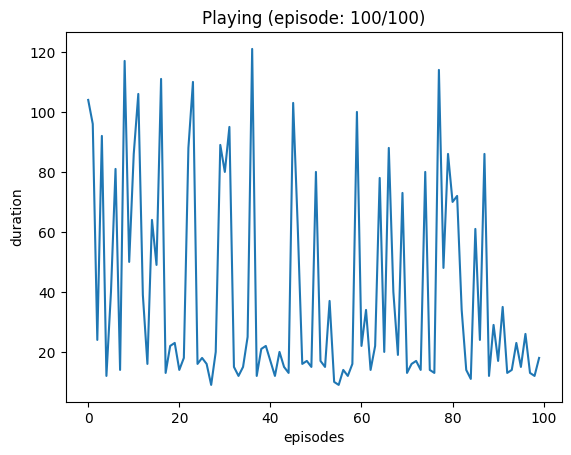

In [11]:
env = gym.make('CartPole-v1', render_mode='human').unwrapped

episodes_to_play = 100
timestep_limit = 3500
episode_durations = list()

get_state = lambda: get_curent_screen(env, (image_height, image_width))

for episode in range(episodes_to_play):
    env.reset()
    current_screen = None
    done = False

    full_screen, current_screen = get_state()
    state = np.zeros_like(current_screen)
    
    # time.sleep(1)
    for timestep in count():
        env.render()

        state_input = np.array([state], dtype=np.float32)
        outputs = policy_net.run(None, { input_name: state_input })
        action = np.argmax(outputs[0], axis=1)[0]

        _, reward, done, truncated, info = env.step(action)
        done = done if timestep < timestep_limit else True
        if done:
            full_screen, current_screen = get_state()
            next_state = np.zeros_like(current_screen)
        else:
            s1 = current_screen
            full_screen, s2 = get_state()
            current_screen = s2
            next_state = s1 - s2

        state = next_state

        if done:
            episode_durations.append(timestep)
            plot(episode_durations, title=f'Playing (episode: {episode + 1}/{episodes_to_play})')
            break

In [12]:
env.close()